In [1]:
import os,sys
sys.path.append(os.path.abspath(".."))

In [2]:
from core.modeling.dlrm import DLRMParams, DLRM
import torch
import numpy as np
import pandas as pd
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from core.data import preprocess, get_cols,encode_ids
from core.utils import seed_all, to_csv
import seaborn as sns
import pathlib
sns.set_theme(style="darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
seed = 0
seed_all(seed)
new_model = False

In [25]:
from recommender import Recommender, Request,SimilarMoviesRequest
Recommender.recommend_similar_movies(SimilarMoviesRequest(
    userId=8957,  # the max id
    movieIds=[1],
    start=0,
    count=10,
))

[Recommendation(userId=8957, movieId=51, predicted_rating=9.301739692687988),
 Recommendation(userId=8957, movieId=101, predicted_rating=9.62096118927002),
 Recommendation(userId=8957, movieId=151, predicted_rating=9.59318733215332),
 Recommendation(userId=8957, movieId=200, predicted_rating=8.942975044250488),
 Recommendation(userId=8957, movieId=249, predicted_rating=9.486276626586914),
 Recommendation(userId=8957, movieId=299, predicted_rating=8.964990615844727),
 Recommendation(userId=8957, movieId=348, predicted_rating=9.495988845825195),
 Recommendation(userId=8957, movieId=398, predicted_rating=9.574234008789062),
 Recommendation(userId=8957, movieId=448, predicted_rating=9.490893363952637),
 Recommendation(userId=8957, movieId=498, predicted_rating=8.938100814819336)]

In [79]:
filename = "dlrm.pt"
max_rating = 10
label = "rating"

In [ ]:
ratings = pd.read_csv("../dataset/db.csv")
ratings = preprocess(ratings,max_rating)
cat_cols, num_cols = get_cols(ratings)
to_csv(ratings, "ratings_processed.csv")
encode_ids(ratings)
nusers = ratings.userId.nunique()
nmovies = ratings.movieId.nunique()
unique = ratings[cat_cols].nunique().tolist()

ratings.head(2)

Saved to ratings_processed.csv


,rating,userId,movieId,movie_year,movie_total_ratings,movie_Action,movie_Adventure,movie_Animation,movie_Biography,movie_Comedy,...,user_movie_Horror_avg_rating,user_movie_Music_avg_rating,user_movie_Mystery_avg_rating,user_movie_Romance_avg_rating,user_movie_Sci-Fi_avg_rating,user_movie_Thriller_avg_rating,user_movie_War_avg_rating,user_movie_Western_avg_rating,movie_avg_rating,user_avg_rating
0,1.0,0,0,0,2,0,0,0,0,0,...,6.000000,0.0,8.750000,0.0,8.75,8.000000,10.0,0.0,9.0,8.933333
1,1.0,1,0,0,2,0,0,0,0,0,...,9.166667,10.0,9.142858,9.0,8.40,9.071428,0.0,10.0,9.0,9.200000


In [58]:
ratings[["userId","movieId"]].max()

userId     6600
movieId     181
dtype: int64

In [59]:
class DS(torch.utils.data.Dataset):
    def __init__(
        self,
        num,
        cat,
        y,
    ) -> None:
        super().__init__()
        self.num = num
        self.cat = cat
        self.y = y

    def __len__(self):
        l = self.num.shape[0]
        return l

    def __getitem__(self, index):
        num = self.num[index]
        cat = self.cat[index]
        y = self.y[index]
        # X,y
        return dict(num=num, cat=cat,y=y)

batch_size = 64
all_ds = DS(
    ratings[num_cols].values,
    ratings[cat_cols].values,
    ratings[label].values,
)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(all_ds,[.8, .1, .1])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
_d=next(iter(train_dl))
_d["num"].dtype, _d["cat"].dtype, _d["y"].dtype

(torch.float32, torch.int64, torch.float32)

In [60]:
model = DLRM(
    DLRMParams(
        model_name="DLRM",
        lr=.001,
        n_users=nusers,
        n_movies=nmovies,
        bot_layers=[len(num_cols), 32*2],
        embds=[(n, 32*2) for n in unique],
        top_layers=[32*2],
        bot_p=.2,
        top_p=.2,
    ),
).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), model.params.lr, weight_decay=0.01)
training_result = None
# model
model.numel()*4/(1024**2)
# params.to_dict()

2.046875

In [61]:
epochs = 1
patience = 5
training_result = model.fit(
    optimizer,
    train_dl,   
    loss_fn=F.mse_loss,
    metric=root_mean_squared_error,
    epochs=epochs,
    val_ld=valid_dl,
    patience=patience,
    last_training_result=training_result
)

Epoch:  1, loss : 0.0104, val_loss: 0.0146: 100%|██████████| 112/112 [00:01<00:00, 86.82it/s]


Model saved.


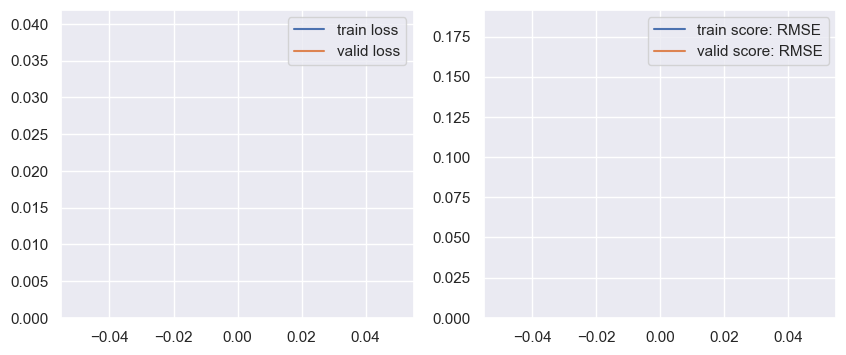

In [62]:
model.save(
    filename,
    optimizer=optimizer,
    last_training_result=training_result,
)
training_result.plot(score_name="RMSE")

In [63]:
model = DLRM.load(filename, model_only=True,device=device)

In [64]:
test = test_ds[:None]
userIds = test["cat"][:, cat_cols.index("userId")]
movieIds = test["cat"][:, cat_cols.index("movieId")]
pred = model.recommend_for_users(
    userIds,
    movieIds,
    max_rating,
)
test = pd.DataFrame(dict(pred=pred,rating=test["y"],userId=userIds,movieId=movieIds))
test["rating"] =test["rating"] * max_rating
test["error"] = test.rating - test.pred

print(f"True: mean {test.rating.mean():.3}, std {test.rating.std():.3}")
print(f"Pred: mean {test.pred.mean():.3}, std {test.pred.std():.3}")
print(f"RSME: {root_mean_squared_error(test.rating,test.pred)}")
test#[["userId", "movieId", "rating", "pred", "error"]].head()

True: mean 7.67, std 3.04
Pred: mean 7.87, std 2.78
RSME: 1.121568370329166


,pred,rating,userId,movieId,error
0,9.967540,10.0,1098,103,0.032460
1,9.287140,6.0,2947,72,-3.287140
2,9.118270,8.0,464,46,-1.118270
3,9.959254,10.0,62,25,0.040746
4,9.378143,7.0,1333,163,-2.378143
...,...,...,...,...,...
890,9.196404,10.0,3021,74,0.803596
891,0.705467,0.0,5419,146,-0.705467
892,0.748517,0.0,5408,146,-0.748517
893,5.174096,6.0,3140,78,0.825904


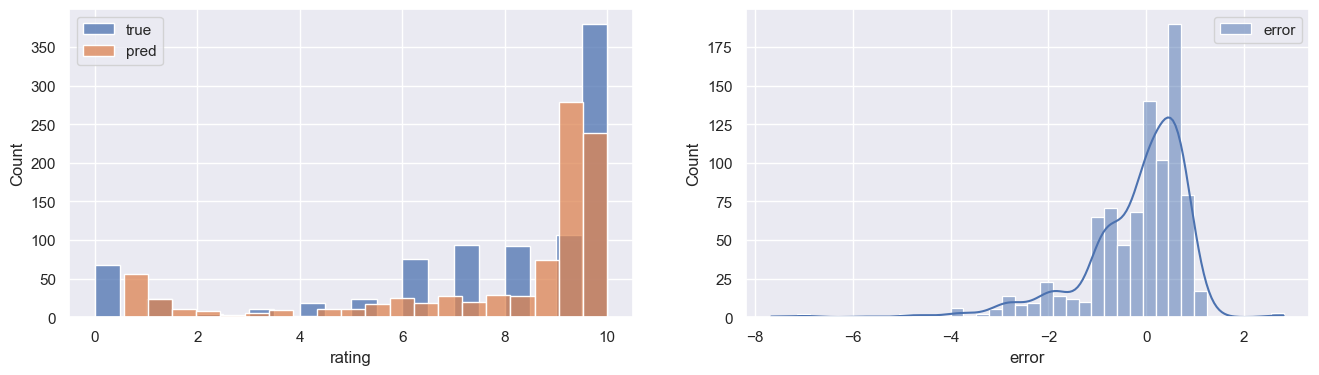

In [65]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(test.error, fill=True, label="error", ax=ax2, kde=True)

sns.histplot(test.rating, fill=True, label="true", ax=ax1, bins=20, kde=False)
sns.histplot(test.pred, fill=True, label="pred", ax=ax1, bins=20, kde=False)
ax1.legend()
ax2.legend()

6600
userId=6600 movieIds=[] genres=[]


[Recommendation(userId=8957, movieId=348, predicted_rating=9.495988845825195),
 Recommendation(userId=8957, movieId=598, predicted_rating=9.320687294006348),
 Recommendation(userId=8957, movieId=1445, predicted_rating=9.389086723327637),
 Recommendation(userId=8957, movieId=1695, predicted_rating=9.307014465332031),
 Recommendation(userId=8957, movieId=2469, predicted_rating=9.039295196533203),
 Recommendation(userId=8957, movieId=2619, predicted_rating=9.354888916015625),
 Recommendation(userId=8957, movieId=3281, predicted_rating=9.36218547821045),
 Recommendation(userId=8957, movieId=5022, predicted_rating=9.294439315795898),
 Recommendation(userId=8957, movieId=8411, predicted_rating=9.252525329589844),
 Recommendation(userId=8957, movieId=8908, predicted_rating=9.309391021728516)]